# Final project notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip3 install -q pybind11
!pip uninstall -q --yes gdown
!pip install -q gdown -U --no-cache-dir
!pip3 install -q --upgrade --no-deps git+https://github.com/dlsys10714/mugrade.git

In [3]:
# Code to set up the assignment
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/
    !mkdir -p 10714
    %cd /content/drive/MyDrive/10714
    !git clone https://github.com/Edyarich/dlsystems-final-project
    %cd /content/drive/MyDrive/10714/dlsystems-final-project

In [5]:
!make

make: *** Не заданы цели и не найден make-файл.  Останов.


In [4]:
import sys
sys.path.append('./python')
sys.path.append('./data/')

In [77]:
# Download the datasets you will be using for this project
import os
import gdown
import importlib
from data.utils import rename_and_filter_images
import urllib.request


%cd ./data
DIRNAME = './landscapes/'

if not os.path.exists(DIRNAME):
    !gdown 14g49ILtIYKLt7WXaRPYyVfJGLHxcnQ7s
    !unzip -q landscapes -d landscapes
    !rm landscapes.zip

    rename_and_filter_images(DIRNAME)

if not os.path.isdir("./cifar-10-batches-py"):
    urllib.request.urlretrieve("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz", "./cifar-10-python.tar.gz")
    !tar -xvzf './cifar-10-python.tar.gz'

%cd ../

/home/eduard/git/dlsystems-final-project/data
/home/eduard/git/dlsystems-final-project


**Создание датасета "Пейзажи"**

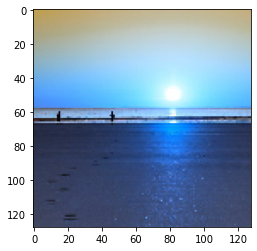

In [20]:
import needle as ndl
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from needle.autograd import Tensor


def plot_landscape(img: np.ndarray):
    img = np.transpose(img, (1, 2, 0))
    img = (img + 1) / 2
    plt.imshow(img);


DATA_DIR = Path('./data/landscapes/')
IMAGE_FILES = sorted(str(x) for x in list(DATA_DIR.rglob('*.jpg')))

transforms = [
    ndl.data.RandomFlipHorizontal(),
    ndl.data.Lambda(lambda img: np.transpose(img, (2, 0, 1))),
]

dataset = ndl.data.LandscapesDataset(
    IMAGE_FILES, extra_transforms=transforms, img_size=128
)
plot_landscape(dataset[12])

**Работа с даталоадером**

In [14]:
dataloader = ndl.data.DataLoader(dataset, batch_size=8)

for batch in dataloader:
    break
    
batch

needle.Tensor([[[[-0.03823529 -0.01378676 -0.01587776 ... -0.27058822 -0.27058822
    -0.27058822]
   [-0.05098039 -0.04313725 -0.03000153 ... -0.27058822 -0.27058822
    -0.27058822]
   [-0.06997549 -0.05324754 -0.05198376 ... -0.27745098 -0.27843136
    -0.27843136]
   ...
   [-0.43767616 -0.54407936 -0.4060738  ... -0.3275735  -0.2516544
    -0.45902267]
   [-0.5916897  -0.4124387  -0.3243719  ... -0.29710478 -0.66760117
    -0.8066789 ]
   [-0.9357154  -0.6149969  -0.42015165 ... -0.41815257 -0.36354166
    -0.2882123 ]]

  [[-0.18725489 -0.16280636 -0.16489735 ... -0.45098037 -0.45098037
    -0.45098037]
   [-0.19999999 -0.19215685 -0.17902113 ... -0.45098037 -0.45098037
    -0.45098037]
   [-0.21899508 -0.20226714 -0.20100336 ... -0.45784312 -0.4588235
    -0.4588235 ]
   ...
   [-0.53179383 -0.638197   -0.4982307  ... -0.37463233 -0.2987132
    -0.50608146]
   [-0.68580735 -0.5065564  -0.41652876 ... -0.3441636  -0.71466
    -0.8537378 ]
   [-0.95804226 -0.6287224  -0.51917124 .

**Тесты на MaxPool и ConvTranspose**

In [13]:
!python3 -m pytest -l -v -k "op_maxpool"

============================= test session starts ==============================
platform linux -- Python 3.9.13, pytest-7.2.0, pluggy-1.0.0 -- /home/eduard/anaconda3/envs/python/bin/python3
cachedir: .pytest_cache
rootdir: /home/eduard/git/dlsystems-final-project
collected 1851 items / 1803 deselected / 48 selected                           

tests/test_conv.py::test_op_maxpool[backward-needle.backend_ndarray.ndarray_backend_cpu-X_shape0-2] PASSED [  2%]
tests/test_conv.py::test_op_maxpool[backward-needle.backend_ndarray.ndarray_backend_cpu-X_shape1-2] PASSED [  4%]
tests/test_conv.py::test_op_maxpool[backward-needle.backend_ndarray.ndarray_backend_cpu-X_shape2-2] PASSED [  6%]
tests/test_conv.py::test_op_maxpool[backward-needle.backend_ndarray.ndarray_backend_cpu-X_shape3-2] PASSED [  8%]
tests/test_conv.py::test_op_maxpool[backward-needle.backend_ndarray.ndarray_backend_cpu-X_shape4-2] PASSED [ 10%]
tests/test_conv.py::test_op_maxpool[backward-needle.backend_ndarray.ndarray_backend_

In [71]:
!python3 -m pytest -l -v -s -k "nn_conv_tr_forward"

============================= test session starts ==============================
platform linux -- Python 3.9.13, pytest-7.2.0, pluggy-1.0.0 -- /home/eduard/anaconda3/envs/python/bin/python3
cachedir: .pytest_cache
rootdir: /home/eduard/git/dlsystems-final-project
collected 1883 items / 1867 deselected / 16 selected                           

tests/test_conv.py::test_nn_conv_tr_forward[needle.backend_ndarray.ndarray_backend_cpu-2-1-1-3-2-1] PASSED
tests/test_conv.py::test_nn_conv_tr_forward[needle.backend_ndarray.ndarray_backend_cpu-2-1-2-3-2-1] PASSED
tests/test_conv.py::test_nn_conv_tr_forward[needle.backend_ndarray.ndarray_backend_cpu-4-8-8-3-1-0] PASSED
tests/test_conv.py::test_nn_conv_tr_forward[needle.backend_ndarray.ndarray_backend_cpu-4-8-16-3-2-1] PASSED
tests/test_conv.py::test_nn_conv_tr_forward[needle.backend_ndarray.ndarray_backend_cpu-16-8-16-3-1-1] PASSED
tests/test_conv.py::test_nn_conv_tr_forward[needle.backend_ndarray.ndarray_backend_cpu-16-16-8-3-2-2] PASSED
tests/t

In [75]:
!python3 -m pytest -l -v -k "nn_conv_tr_backward"

============================= test session starts ==============================
platform linux -- Python 3.9.13, pytest-7.2.0, pluggy-1.0.0 -- /home/eduard/anaconda3/envs/python/bin/python3
cachedir: .pytest_cache
rootdir: /home/eduard/git/dlsystems-final-project
collected 1881 items / 1867 deselected / 14 selected                           

tests/test_conv.py::test_nn_conv_tr_backward[needle.backend_ndarray.ndarray_backend_cpu-2-1-1-3-2-1] PASSED [  7%]
tests/test_conv.py::test_nn_conv_tr_backward[needle.backend_ndarray.ndarray_backend_cpu-2-1-2-3-2-1] PASSED [ 14%]
tests/test_conv.py::test_nn_conv_tr_backward[needle.backend_ndarray.ndarray_backend_cpu-4-8-8-3-1-0] PASSED [ 21%]
tests/test_conv.py::test_nn_conv_tr_backward[needle.backend_ndarray.ndarray_backend_cpu-4-8-16-3-2-1] PASSED [ 28%]
tests/test_conv.py::test_nn_conv_tr_backward[needle.backend_ndarray.ndarray_backend_cpu-16-8-16-3-1-1] PASSED [ 35%]
tests/test_conv.py::test_nn_conv_tr_backward[needle.backend_ndarray.ndarray_

In [16]:
import torch


arr = torch.rand(5, 3, 4)
arr = arr[(..., ) + (None, ) * 2]
arr.shape

torch.Size([5, 3, 4, 1, 1])

In [ ]:
class Block(Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = Conv(2*in_ch, out_ch, 3, padding=1)
            self.transform = ConvTranspose(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = Conv(in_ch, out_ch, 3, padding=1)
            self.transform = Conv(out_ch, out_ch, 4, 2, 1)
        self.conv2 = Conv(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = BatchNorm2d(out_ch)
        self.bnorm2 = BatchNorm2d(out_ch)
        self.relu = ReLU()
 
    def forward(self, x, t):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb.reshape(time_emb.shape + (1, 1))
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class Unet(Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 16
 
        # Time embedding
        self.time_mlp = Sequential(
            SinusoidalPosEmb(time_emb_dim),
            Linear(time_emb_dim, time_emb_dim),
            ReLU()
        )
 
        # Initial projection
        self.conv0 = Conv(image_channels, down_channels[0], 3, padding=1)
 
        # Downsample
        self.downs = []
        # Upsample
        self.ups = []
        
        for i in range(len(down_channels) - 1):
            self.downs.append(
                Block(down_channels[i], down_channels[i+1], time_emb_dim)
            )
            setattr(self, f'down_block_{i}', self.downs[-1])
            
        for i in range(len(up_channels) - 1):
            self.ups.append(
                Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True)
            )
            setattr(self, f'up_block_{i}', self.ups[-1])
 
        self.output = Conv(up_channels[-1], 3, out_dim)
 
    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = ops.stack((x, residual_x), dim=1)           
            x = up(x, t)
        
        return self.output(x)

In [ ]:


mask = -2 * (X < 0) + 1